In [59]:
!pip install deap pygad

In [60]:
from deap import base, creator, tools, algorithms
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Estilo visual general para publicación
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300
})

In [61]:
data = pd.read_csv("datos_cursos.csv")

In [62]:
# Mostrar valores únicos de horarios de inicio y fin
print("H_Inicio únicos:", sorted(data['H_Inicio'].unique()))
print("H_Salida únicos:", sorted(data['H_Salida'].unique()))

H_Inicio únicos: [np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18)]
H_Salida únicos: [np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20)]


In [63]:
# Filtrar cursos que tengan horas fuera del rango permitido
outliers = data[(data['H_Inicio'] == 20) | (data['H_Salida'] == 22)]
print(outliers)

Empty DataFrame
Columns: [Facultad, Carrera, Día, H_Inicio, H_Salida, Año_Inicio, Año_Fin, Total Estudiantes, Proyecto, Entrada, Salida, Profesor]
Index: []


In [64]:
filtro = (
    (data['Facultad'] == 'ICA') &
    (data['Carrera'] == 'CIVIL') &
    (data['Día'] == 'VIERNES') &
    (data['H_Inicio'] == 20.0) &
    (data['H_Salida'] == 22.0) &
    (data['Profesor'] == 'DOC_10')
)

# Aplicar la corrección
data.loc[filtro, 'H_Inicio'] = 18.0
data.loc[filtro, 'H_Salida'] = 20.0

In [65]:
data['H_Inicio'].unique()

array([ 7, 11,  8,  9, 16, 18, 15, 10, 12, 14, 17, 13])

In [66]:
# Dividir el dataset
df = data[(data['Año_Inicio'] == 2024) & (data['Año_Fin'] == 2025)].copy()


In [67]:
df_cursos = df[['Facultad', 'Carrera', 'Día', 'H_Inicio', 'H_Salida', 'Total Estudiantes', 'Año_Inicio', 'Año_Fin']].reset_index(drop=True)
df_docentes = df[['Profesor', 'Entrada', 'Salida', 'Proyecto']].drop_duplicates().dropna().reset_index(drop=True)

df_cursos.to_csv('datos_facultades.csv', index=False)
df_docentes.to_csv('datos_docentes.csv', index=False)

display(df_cursos)
display(df_docentes)

,Facultad,Carrera,Día,H_Inicio,H_Salida,Total Estudiantes,Año_Inicio,Año_Fin
0,CQ,QUIMICA,LUNES,9,11,19,2024,2025
1,FILO,P MATEMATICA,MARTES,10,12,50,2024,2025
2,CQ,QUIMICA,MIERCOLES,10,12,39,2024,2025
3,ICA,CIVIL,MIERCOLES,11,13,35,2024,2025
4,CQ,QUIMICA,MIERCOLES,11,13,35,2024,2025
...,...,...,...,...,...,...,...,...
77,CQ,BIO Y FAR,VIERNES,7,9,53,2024,2025
78,FILO,P MATEMATICA,VIERNES,11,13,47,2024,2025
79,ARQ,ARQUITECTURA,VIERNES,13,15,24,2024,2025
80,AGR,AGRONOMIA,VIERNES,11,13,26,2024,2025


,Profesor,Entrada,Salida,Proyecto
0,DOC_08,7,15,1
1,DOC_11,7,15,0
2,DOC_13,7,15,1
3,DOC_03,7,15,1
4,DOC_05,7,15,1
5,DOC_07,12,20,0
6,DOC_10,7,15,1
7,DOC_01,12,20,0
8,DOC_04,10,18,0
9,DOC_14,12,20,0


In [68]:
# Preprocesamiento
df['H_Inicio'] = df['H_Inicio'].astype(int)
df['H_Salida'] = df['H_Salida'].astype(int)
df_docentes['Entrada'] = df_docentes['Entrada'].astype(int)
df_docentes['Salida'] = df_docentes['Salida'].astype(int)
df_docentes['Proyecto'] = df_docentes['Proyecto'].astype(int)

# Variables globales
NUM_DOCENTES = len(df_docentes)
NUM_CURSOS = len(df)

print(f"Número de docentes: {NUM_DOCENTES}")
print(f"Número de cursos: {NUM_CURSOS}")

Número de docentes: 14
Número de cursos: 82


In [69]:
# Crear clases para el algoritmo genético
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_docente", random.randint, 0, NUM_DOCENTES - 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_docente, n=NUM_CURSOS)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [70]:
# Función de evaluación
def evaluar(individuo):
    penalizacion = 0
    asignaciones = {i: [] for i in range(NUM_DOCENTES)}
    carga_docente = np.zeros(NUM_DOCENTES)
    estudiantes_docente = np.zeros(NUM_DOCENTES)

    for i, docente_idx in enumerate(individuo):
        curso = df_cursos.iloc[i]
        docente = df_docentes.iloc[docente_idx]

        if curso['H_Inicio'] < docente['Entrada'] or curso['H_Salida'] > docente['Salida']:
            penalizacion += 5

        for asignado in asignaciones[docente_idx]:
            if curso['Día'] == asignado['Día']:
                if not (curso['H_Salida'] <= asignado['H_Inicio'] or curso['H_Inicio'] >= asignado['H_Salida']):
                    penalizacion += 10

        asignaciones[docente_idx].append(curso)
        carga_docente[docente_idx] += 1
        estudiantes_docente[docente_idx] += curso['Total Estudiantes']

    for idx, docente in df_docentes.iterrows():
        max_cursos = 7 if docente['Proyecto'] == 1 else 9
        if carga_docente[idx] > max_cursos:
            penalizacion += (carga_docente[idx] - max_cursos) * 3

    desviacion = np.std(estudiantes_docente)
    penalizacion += desviacion

    return (penalizacion,)

In [71]:
# Registro de operadores
toolbox.register("evaluate", evaluar)
toolbox.register("mate", tools.cxUniform, indpb=0.2)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=NUM_DOCENTES - 1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# Ejecutar algoritmo
poblacion = toolbox.population(n=100)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("avg", np.mean)

resultado, log = algorithms.eaSimple(poblacion, toolbox, cxpb=0.7, mutpb=0.2, ngen=100, stats=stats, halloffame=hof, verbose=True)



gen	nevals	min    	max    	avg    
0  	100   	229.231	456.214	338.354
1  	80    	209.036	409.9  	308.685
2  	82    	203.263	362.967	280.263
3  	78    	195.816	346.522	265.916
4  	74    	200.88 	364.192	255.176
5  	80    	199.551	358.082	244.614
6  	67    	180.716	320.32 	233.501
7  	78    	179.436	319.049	225.519
8  	82    	158.25 	291.795	213.181
9  	64    	161.953	266.785	199.764
10 	88    	154.249	250.294	194.078
11 	74    	154.083	258.824	188.778
12 	72    	142.892	261.142	184.542
13 	82    	141.893	276.341	176.879
14 	85    	127.49 	229.375	173.318
15 	77    	126.783	276.57 	167.436
16 	68    	126.783	237.847	166.378
17 	79    	116.509	223.152	160.239
18 	71    	124.79 	204.304	153.94 
19 	82    	108.678	225.467	148.57 
20 	82    	102.428	215.087	148.629
21 	72    	103.944	243.999	146.611
22 	76    	109.9  	230.685	139.305
23 	58    	109.038	209.675	134.574
24 	80    	109.038	220.04 	138.347
25 	81    	98.5741	221.903	131.584
26 	85    	98.5741	195.663	128.647
27 	80    	97.2845	2

In [72]:
# Mostrar resultados
mejor_individuo = hof[0]
asignaciones_finales = df_cursos.copy()
asignaciones_finales['Docente_Asignado'] = [df_docentes.iloc[i]['Profesor'] for i in mejor_individuo]

print(asignaciones_finales)

   Facultad       Carrera        Día  H_Inicio  H_Salida  Total Estudiantes  \
0        CQ       QUIMICA      LUNES         9        11                 19   
1      FILO  P MATEMATICA     MARTES        10        12                 50   
2        CQ       QUIMICA  MIERCOLES        10        12                 39   
3       ICA         CIVIL  MIERCOLES        11        13                 35   
4        CQ       QUIMICA  MIERCOLES        11        13                 35   
..      ...           ...        ...       ...       ...                ...   
77       CQ     BIO Y FAR    VIERNES         7         9                 53   
78     FILO  P MATEMATICA    VIERNES        11        13                 47   
79      ARQ  ARQUITECTURA    VIERNES        13        15                 24   
80      AGR     AGRONOMIA    VIERNES        11        13                 26   
81     FILO   MECATRONICA    VIERNES        14        16                 61   

    Año_Inicio  Año_Fin Docente_Asignado  
0       

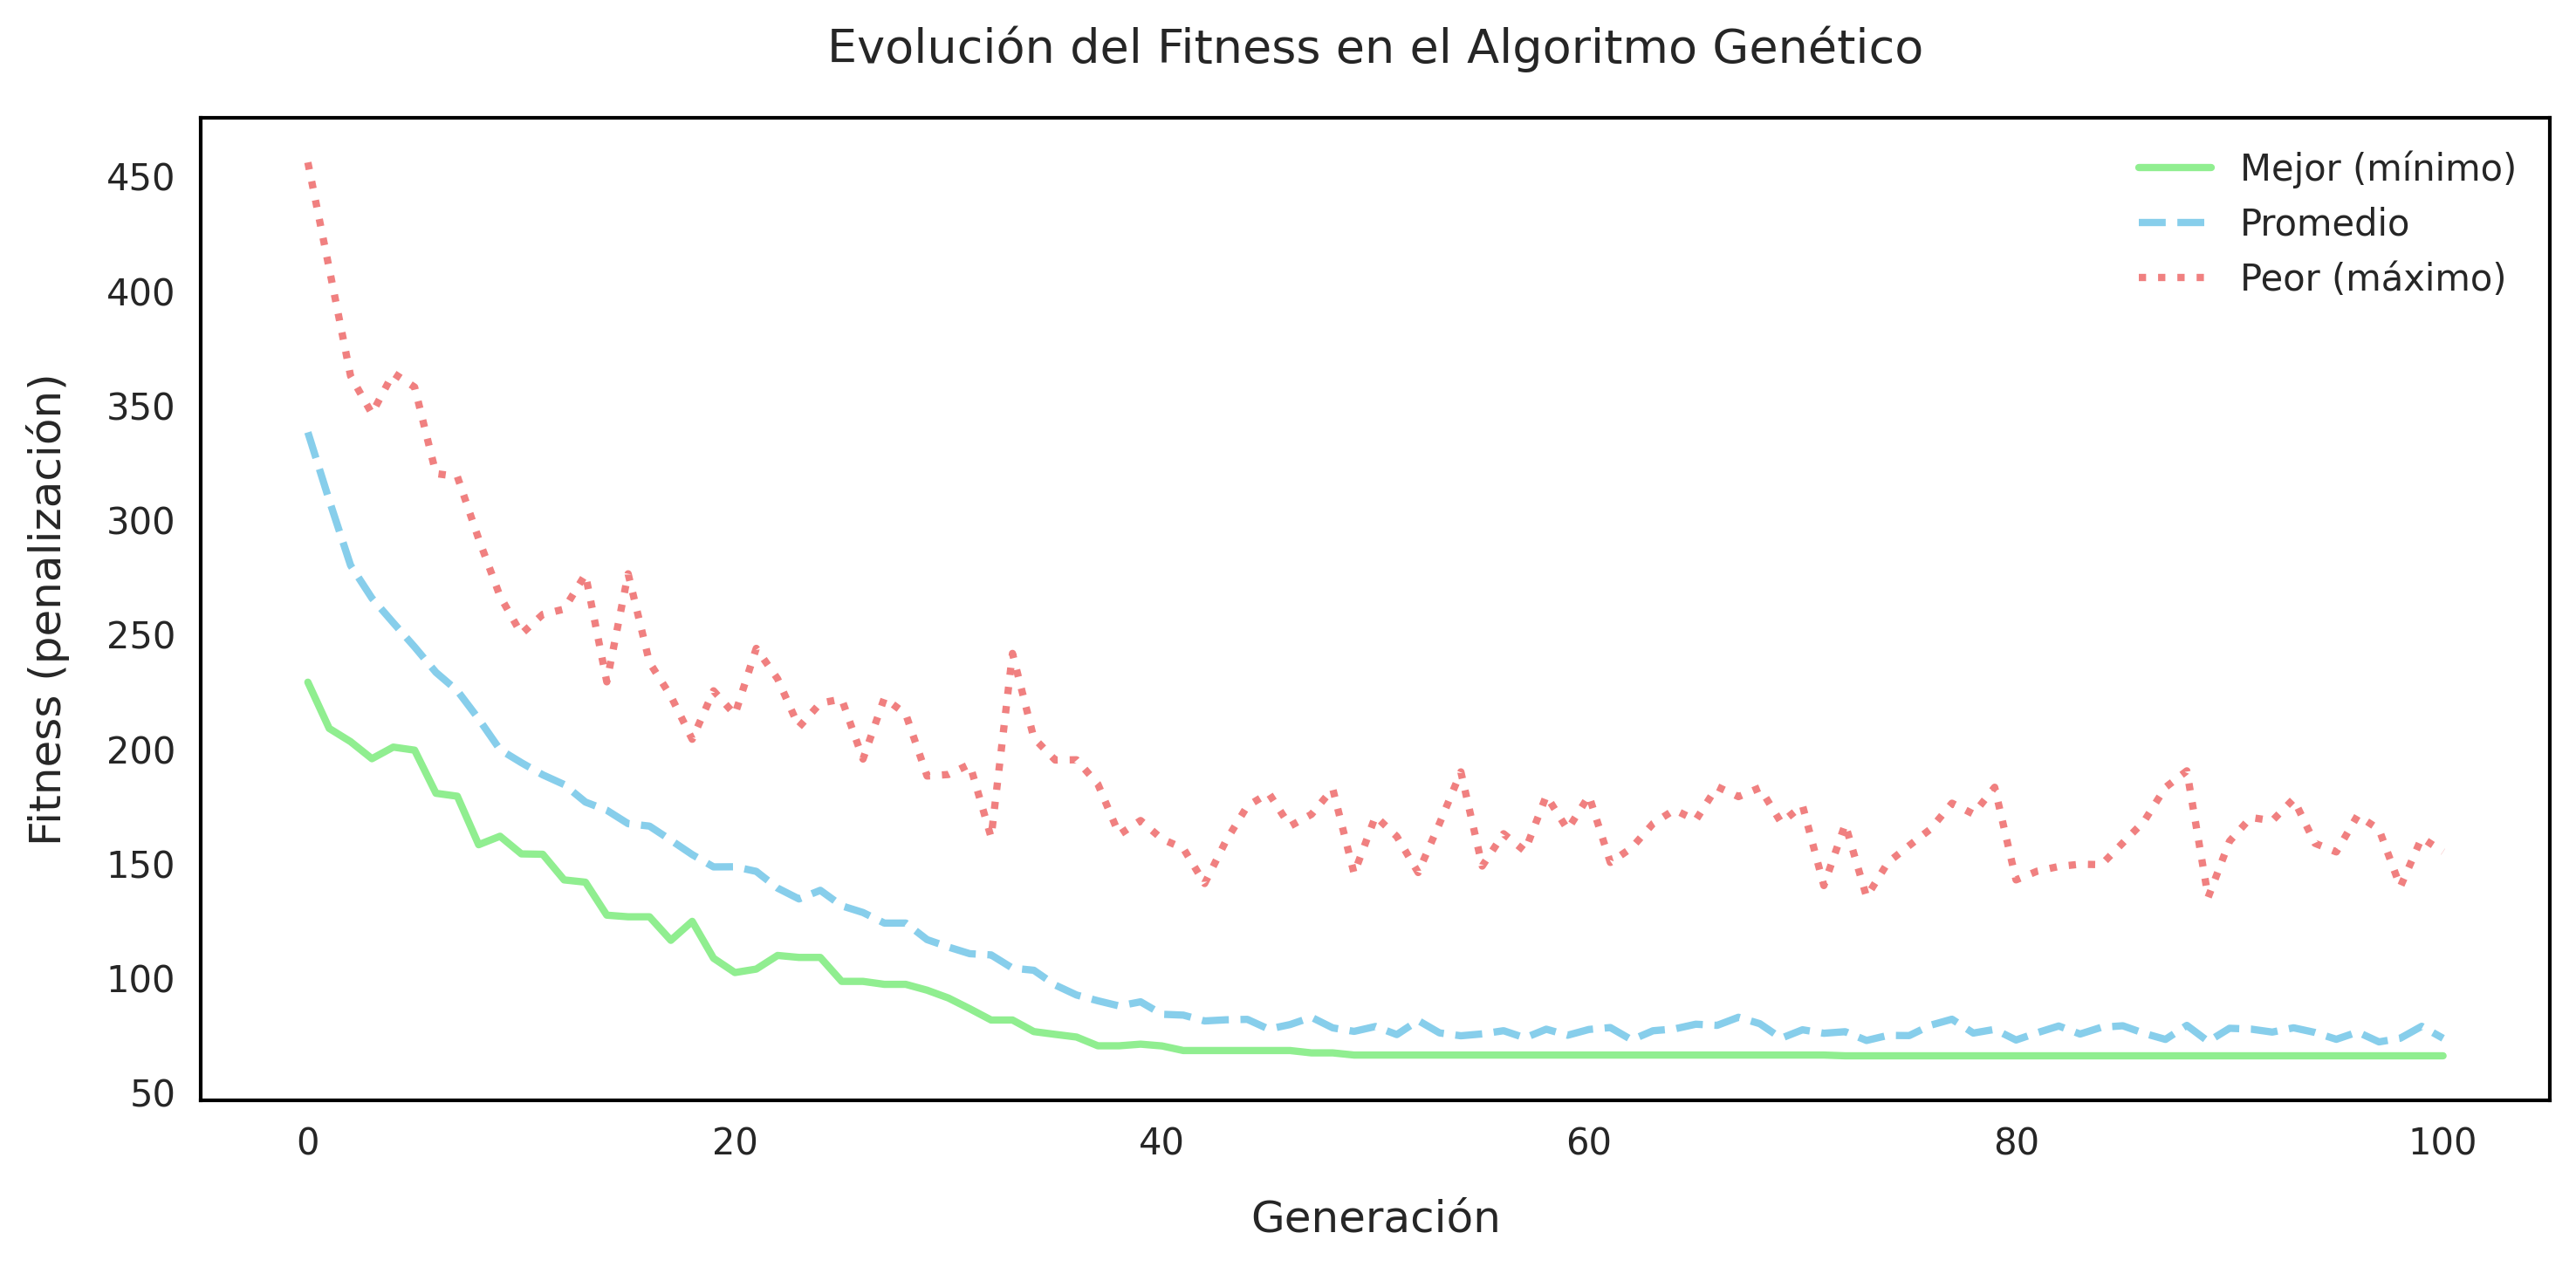

In [73]:
# Estilo limpio con fondo blanco y ejes visibles
sns.set_style("white")
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['font.size'] = 12

# Datos
generaciones = log.select("gen")
minimos = log.select("min")
promedios = log.select("avg")
maximos = log.select("max")

# Crear figura
fig, ax = plt.subplots(figsize=(10, 5))

# Graficar líneas
ax.plot(generaciones, minimos, label="Mejor (mínimo)", color='lightgreen', linewidth=2)
ax.plot(generaciones, promedios, label="Promedio", linestyle='--', color='skyblue', linewidth=2)
ax.plot(generaciones, maximos, label="Peor (máximo)", linestyle=':', color='lightcoral', linewidth=2)

# Etiquetas y título
ax.set_xlabel("Generación", labelpad=10)
ax.set_ylabel("Fitness (penalización)", labelpad=10)
ax.set_title("Evolución del Fitness en el Algoritmo Genético", pad=15)

# Enmarcar todos los bordes
for spine in ax.spines.values():
    spine.set_visible(True)

# Fondo blanco
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# Leyenda y presentación
ax.legend(frameon=False, loc='upper right')
plt.tight_layout()
plt.show()

In [74]:
# Crear el DataFrame final combinando la información de los cursos con los docentes asignados
asignacion_cursos = df_cursos.copy()

# Agregar una columna con el nombre del docente asignado a cada curso
asignacion_cursos['Docente_Asignado'] = [df_docentes.iloc[i]['Profesor'] for i in mejor_individuo]

# Mostrar el resultado
print(asignacion_cursos.head())

# (Opcional) Guardar en archivo CSV
asignacion_cursos.to_csv("asignacion_cursos.csv", index=False)

  Facultad       Carrera        Día  H_Inicio  H_Salida  Total Estudiantes  \
0       CQ       QUIMICA      LUNES         9        11                 19   
1     FILO  P MATEMATICA     MARTES        10        12                 50   
2       CQ       QUIMICA  MIERCOLES        10        12                 39   
3      ICA         CIVIL  MIERCOLES        11        13                 35   
4       CQ       QUIMICA  MIERCOLES        11        13                 35   

   Año_Inicio  Año_Fin Docente_Asignado  
0        2024     2025           DOC_06  
1        2024     2025           DOC_13  
2        2024     2025           DOC_10  
3        2024     2025           DOC_09  
4        2024     2025           DOC_12  


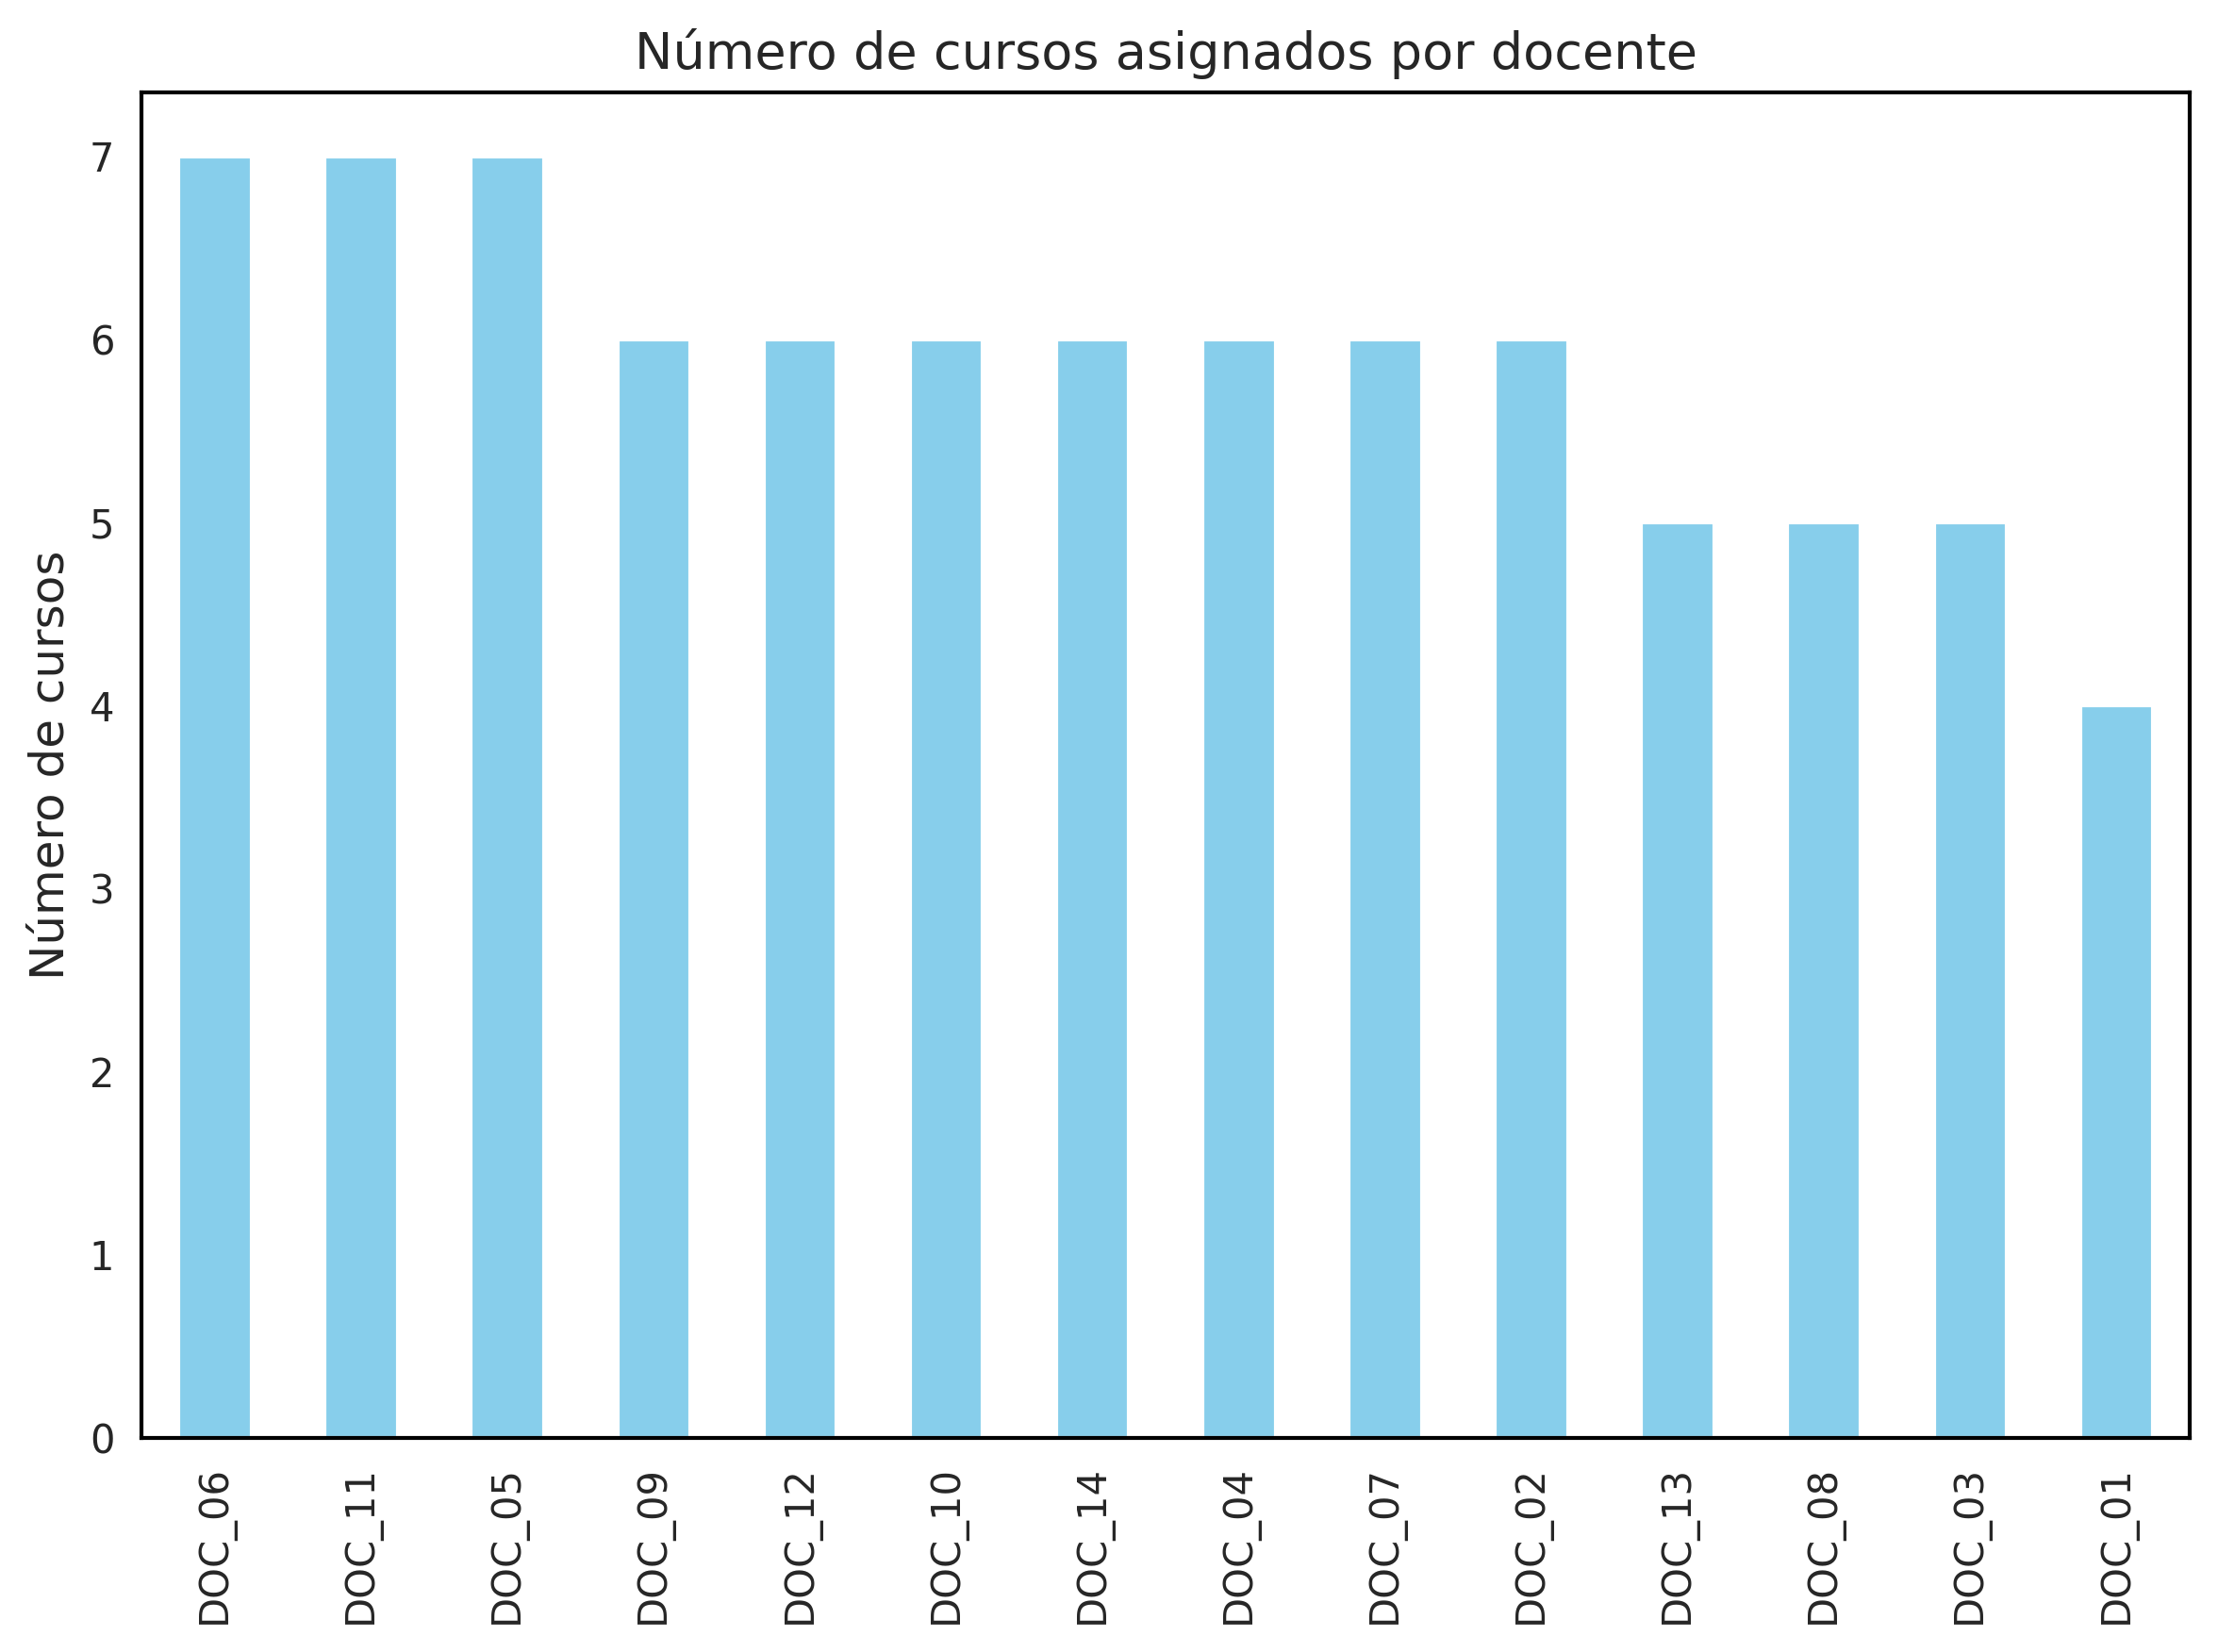

In [75]:
# Contar cuántos cursos tiene asignado cada docente
conteo_cursos = asignacion_cursos['Docente_Asignado'].value_counts().sort_values(ascending=False)

# Crear gráfica de barras
plt.figure(figsize=(8, 6))
conteo_cursos.plot(kind='bar', color='skyblue')
plt.title("Número de cursos asignados por docente")
plt.xlabel("")
plt.ylabel("Número de cursos")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [76]:
# Asegurarse de que los nombres de columnas son consistentes
df_original = df.copy()

# Contar número de cursos por docente en el dataset original
cursos_originales = df_original['Profesor'].value_counts()

# Contar número de cursos en la nueva asignación
cursos_optimizados = asignacion_cursos['Docente_Asignado'].value_counts()

# Combinar ambos conteos en un mismo DataFrame
comparacion = pd.DataFrame({
    'Original': cursos_originales,
    'Optimizado': cursos_optimizados
}).fillna(0).astype(int)

# Ordenar por la suma total para claridad visual
comparacion = comparacion.sort_values(by=['Original', 'Optimizado'], ascending=False)

In [78]:
#se ve la desviacion si es menor se interpreta que es mejor
carga_original = df['Profesor'].value_counts()
carga_optima = asignacion_cursos['Docente_Asignado'].value_counts()

print(f"Desviación estándar de cursos (original): {carga_original.std():.2f}")
print(f"Desviación estándar de cursos (optimizado): {carga_optima.std():.2f}")

Desviación estándar de cursos (original): 1.61
Desviación estándar de cursos (optimizado): 0.86


In [79]:
# Total de estudiantes por docente
estudiantes_original = df.groupby('Profesor')['Total Estudiantes'].sum()
estudiantes_optimo = asignacion_cursos.groupby('Docente_Asignado')['Total Estudiantes'].sum()

print(f"Desviación estándar de estudiantes (original): {estudiantes_original.std():.2f}")
print(f"Desviación estándar de estudiantes (optimizado): {estudiantes_optimo.std():.2f}")

Desviación estándar de estudiantes (original): 52.34
Desviación estándar de estudiantes (optimizado): 16.68


In [87]:
sin_proyecto = df_docentes[df_docentes['Proyecto'] == 0]['Profesor']
sobrecargados = asignacion_cursos['Docente_Asignado'].value_counts()
violaciones = sobrecargados[sin_proyecto].loc[lambda x: x > 9]
print("Docentes sin proyecto con más de 8 cursos asignados:")
print(violaciones)

Docentes sin proyecto con más de 8 cursos asignados:
Series([], Name: count, dtype: int64)


In [88]:
def hay_cruce(df_asignado):
    for docente, cursos_doc in df_asignado.groupby('Docente_Asignado'):
        horarios = cursos_doc[['Día', 'H_Inicio', 'H_Salida']].values
        for i in range(len(horarios)):
            for j in range(i + 1, len(horarios)):
                if horarios[i][0] == horarios[j][0]:  # mismo día
                    if not (horarios[i][2] <= horarios[j][1] or horarios[i][1] >= horarios[j][2]):
                        return True
    return False

print("¿Hay cruce de horario en asignación optimizada?", hay_cruce(asignacion_cursos))

¿Hay cruce de horario en asignación optimizada? False


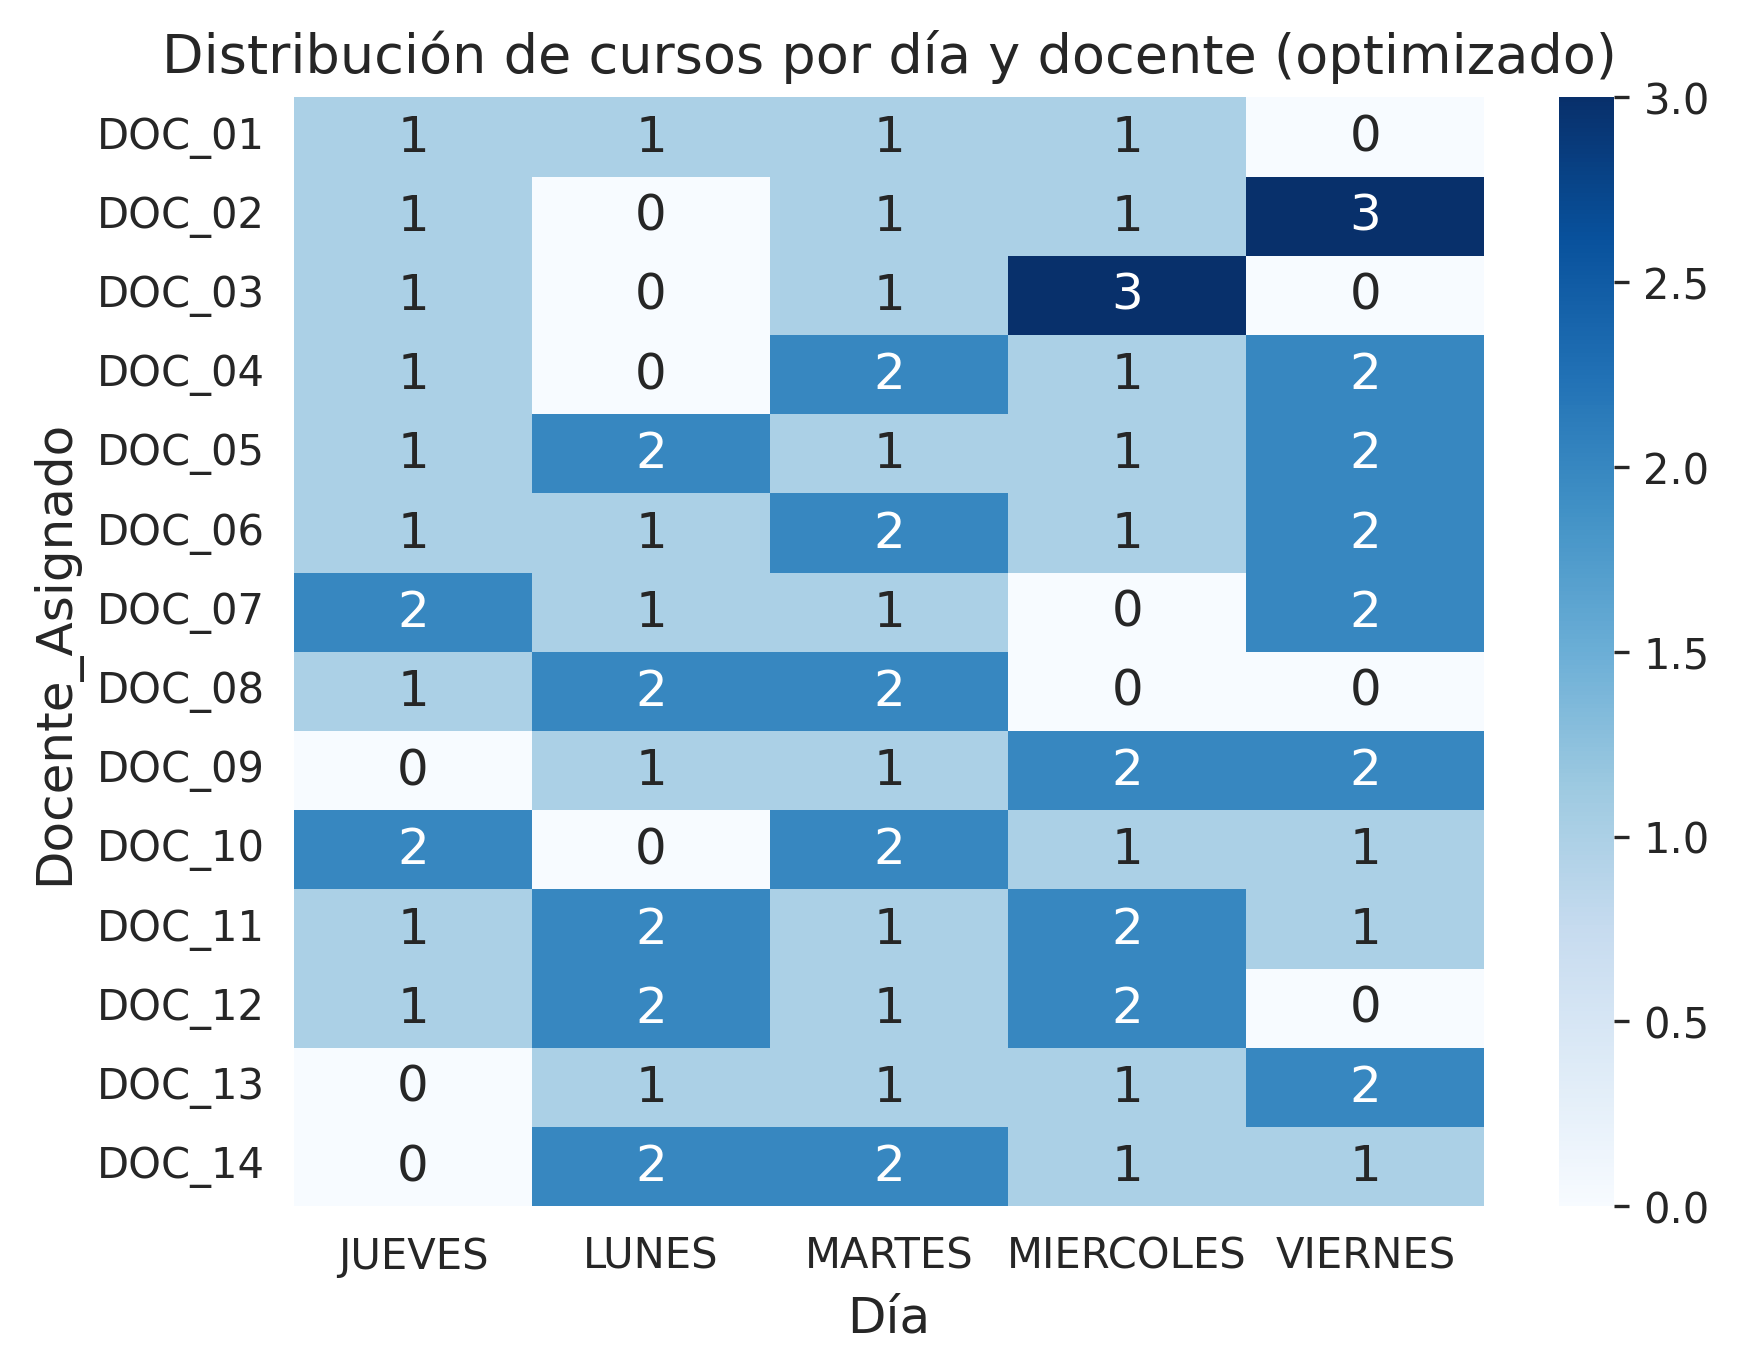

In [82]:
pivot = asignacion_cursos.pivot_table(index='Docente_Asignado', columns='Día', aggfunc='size', fill_value=0)
sns.heatmap(pivot, annot=True, fmt='d', cmap='Blues')
plt.title("Distribución de cursos por día y docente (optimizado)")
plt.show()

In [83]:
print(f"Fitness mínimo encontrado: {min(log.select('min')):.2f}")
print(f"Fitness máximo encontrado: {max(log.select('max')):.2f}")
print(f"Fitness promedio encontrado: {sum(log.select('avg')) / len(log.select('avg')):.2f}")

Fitness mínimo encontrado: 66.07
Fitness máximo encontrado: 456.21
Fitness promedio encontrado: 112.18


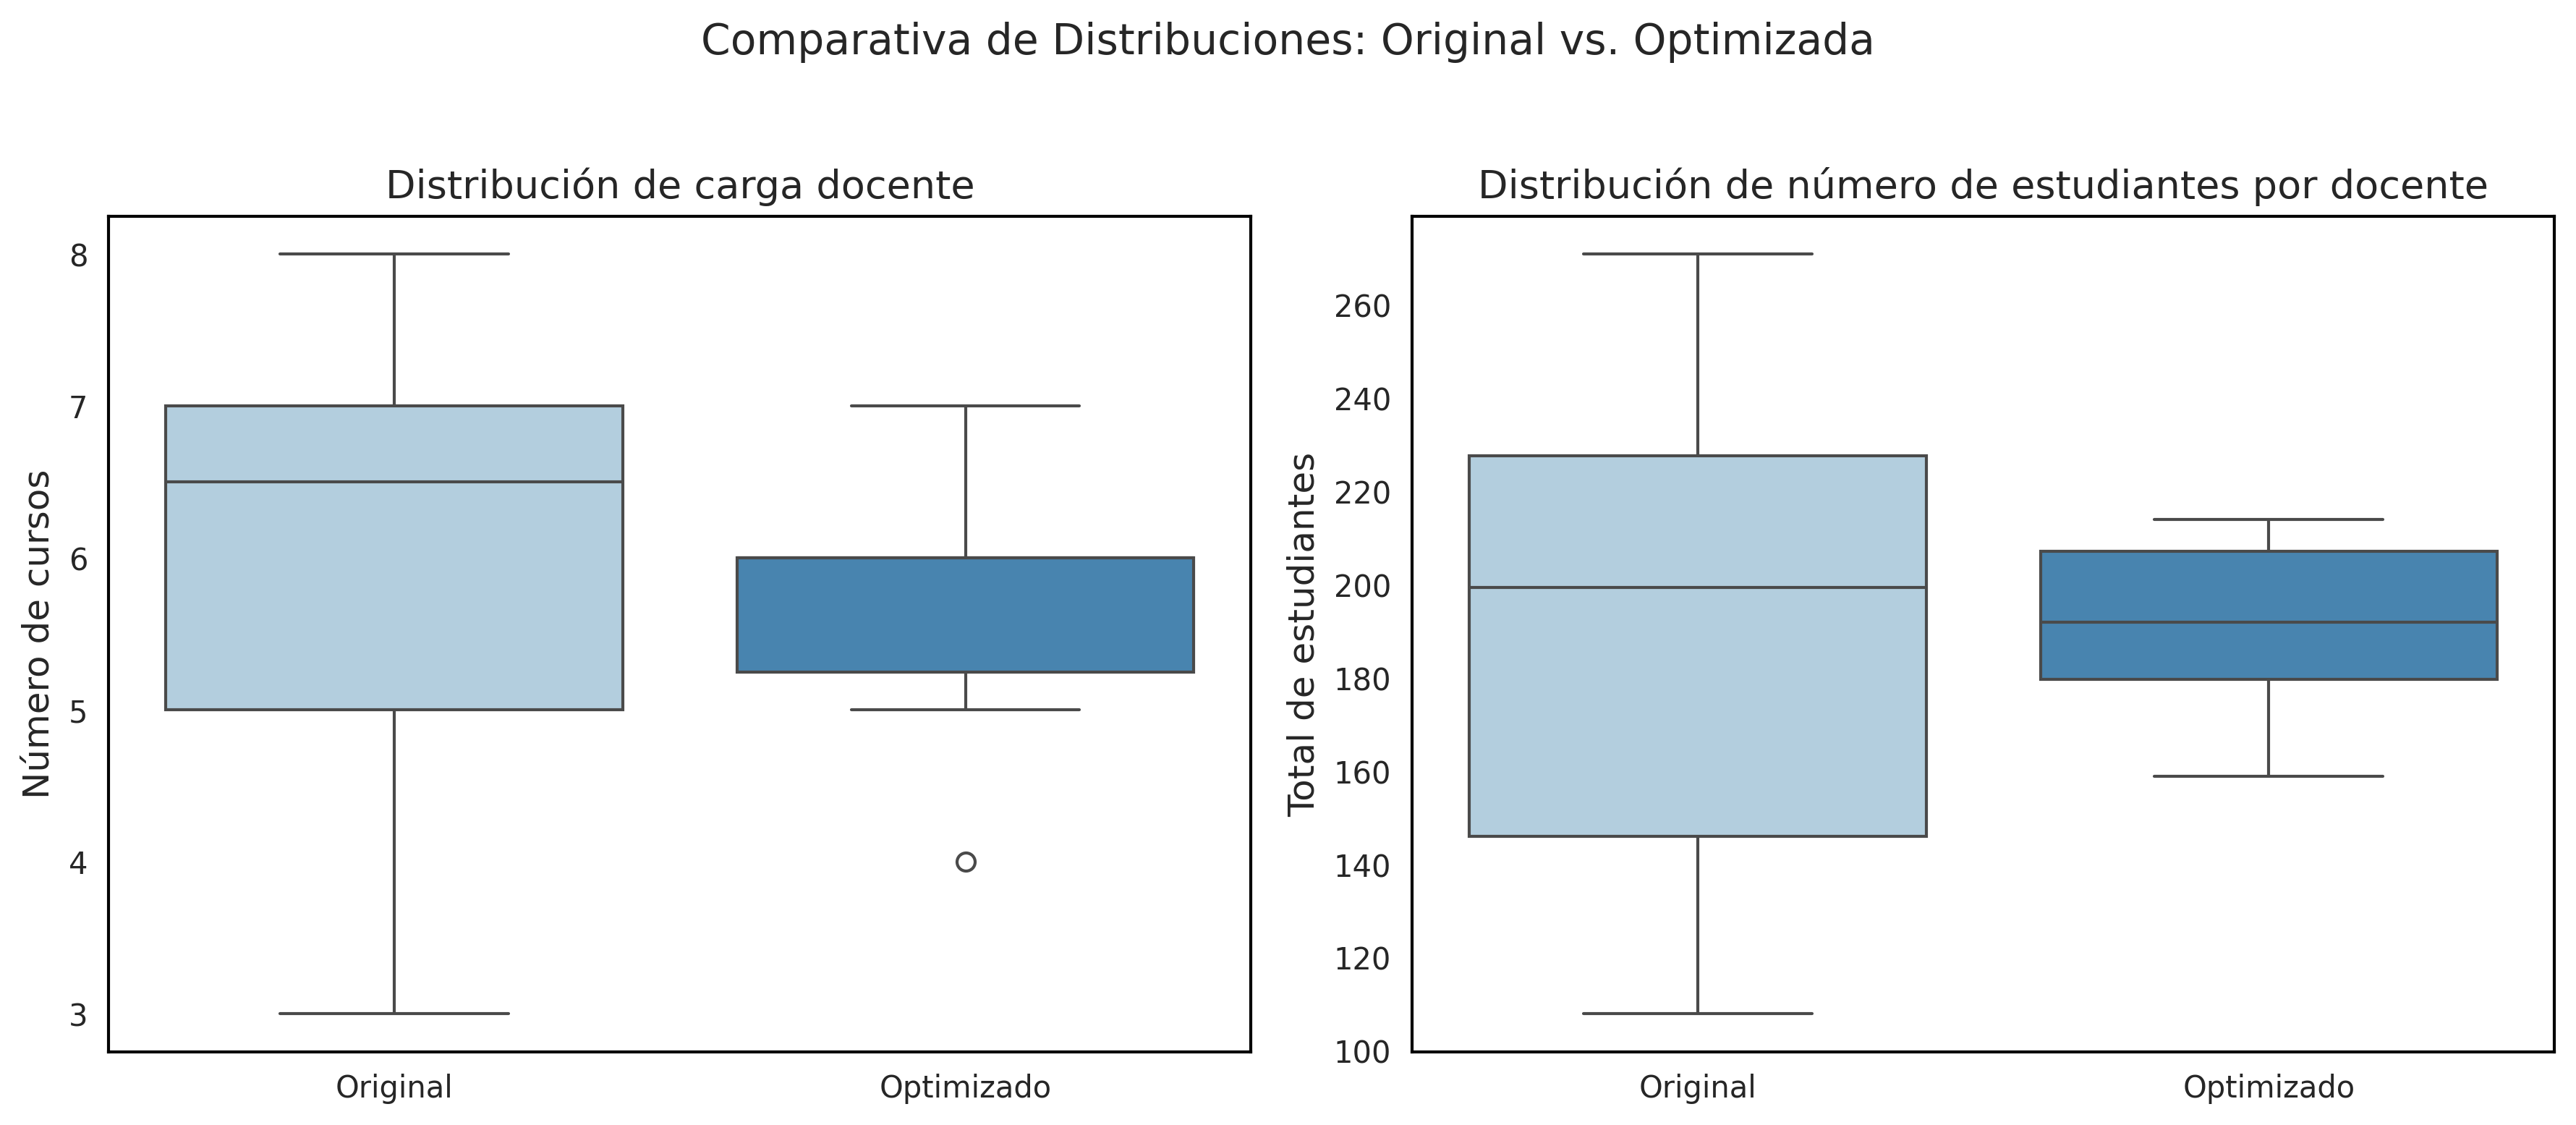

In [84]:
# Datos para el primer gráfico: número de cursos
data_cursos = pd.DataFrame({
    'Original': df['Profesor'].value_counts(),
    'Optimizado': asignacion_cursos['Docente_Asignado'].value_counts()
})

# Datos para el segundo gráfico: total de estudiantes
data_estudiantes = pd.DataFrame({
    'Original': df.groupby('Profesor')['Total Estudiantes'].sum(),
    'Optimizado': asignacion_cursos.groupby('Docente_Asignado')['Total Estudiantes'].sum()
}).fillna(0)

# Estilo limpio
sns.set_style("white")
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['font.size'] = 11

# Crear figura con subplots (1 fila, 2 columnas)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Comparativa de Distribuciones: Original vs. Optimizada", fontsize=14, y=1.03)

# Boxplot: Número de cursos
sns.boxplot(data=data_cursos, ax=axs[0], palette="Blues")
axs[0].set_title("Distribución de carga docente")
axs[0].set_ylabel("Número de cursos")


# Boxplot: Total estudiantes
sns.boxplot(data=data_estudiantes, ax=axs[1], palette="Blues")
axs[1].set_title("Distribución de número de estudiantes por docente")
axs[1].set_ylabel("Total de estudiantes")


# Ajustar diseño
plt.tight_layout()
plt.show()

In [85]:
# Cursos por docente
cursos_original = df['Profesor'].value_counts()
cursos_optimo = asignacion_cursos['Docente_Asignado'].value_counts()

# Estudiantes por docente
estudiantes_original = df.groupby('Profesor')['Total Estudiantes'].sum()
estudiantes_optimo = asignacion_cursos.groupby('Docente_Asignado')['Total Estudiantes'].sum()

# Unir docentes que están en al menos una de las dos asignaciones
todos_docentes = sorted(set(cursos_original.index).union(cursos_optimo.index))

# Crear DataFrame comparativo
comparacion_df = pd.DataFrame(index=todos_docentes)
comparacion_df['Cursos_Original'] = cursos_original
comparacion_df['Cursos_Optimizado'] = cursos_optimo
comparacion_df['Estudiantes_Original'] = estudiantes_original
comparacion_df['Estudiantes_Optimizado'] = estudiantes_optimo
comparacion_df = comparacion_df.fillna(0).astype(int)



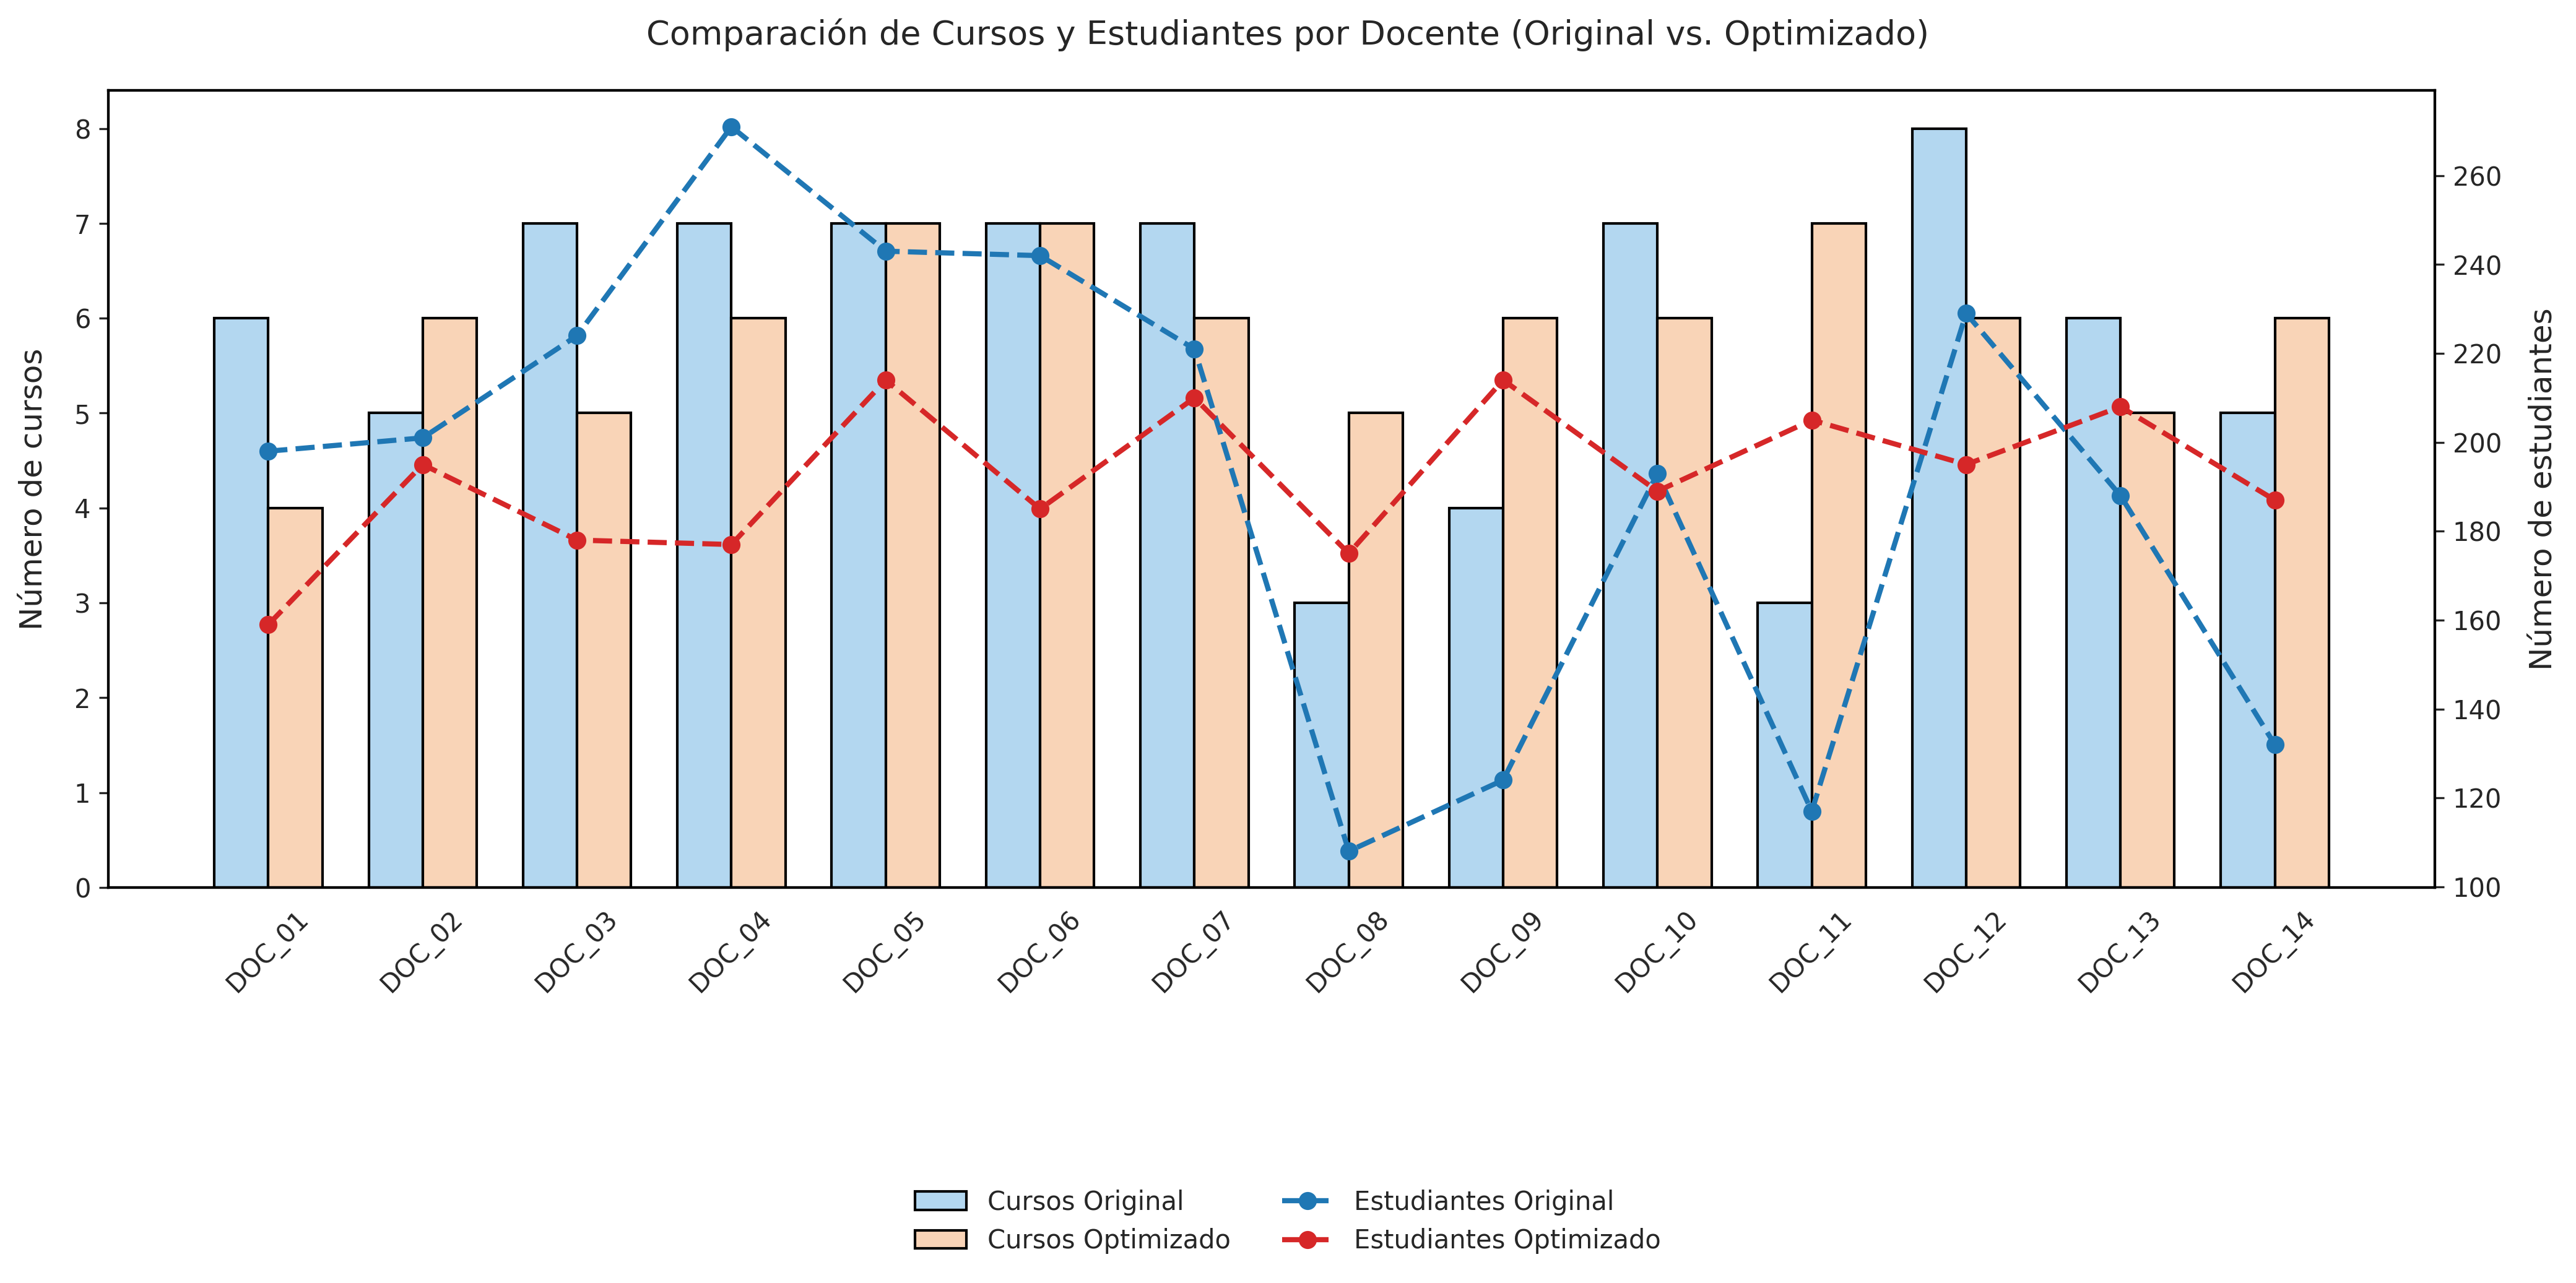

In [89]:
# Estilo limpio y coherente
sns.set_style("white")
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['font.size'] = 11

# Paleta de colores suaves pero diferenciables
color_cursos_orig = "#b3d7f0"         # azul pastel (barras)
color_cursos_opt = "#f9d4b7"          # naranja claro (barras)
color_estudiantes_orig = "#1f77b4"    # azul fuerte (líneas)
color_estudiantes_opt = "#d62728"     # rojo fuerte (líneas)

# Posición x
x = np.arange(len(comparacion_df.index))
width = 0.35

# Figura y ejes
fig, ax1 = plt.subplots(figsize=(14, 6))

# Barras: número de cursos
ax1.bar(x - width/2, comparacion_df['Cursos_Original'], width,
        label='Cursos Original', color=color_cursos_orig, edgecolor='black')
ax1.bar(x + width/2, comparacion_df['Cursos_Optimizado'], width,
        label='Cursos Optimizado', color=color_cursos_opt, edgecolor='black')
ax1.set_ylabel('Número de cursos', labelpad=10)
ax1.set_xlabel('')
ax1.set_xticks(x)
ax1.set_xticklabels(comparacion_df.index, rotation=45)


# Línea: número de estudiantes (eje secundario)
ax2 = ax1.twinx()
ax2.plot(x, comparacion_df['Estudiantes_Original'], color=color_estudiantes_orig,
         marker='o', label='Estudiantes Original', linewidth=2, linestyle='--')
ax2.plot(x, comparacion_df['Estudiantes_Optimizado'], color=color_estudiantes_opt,
         marker='o', label='Estudiantes Optimizado', linewidth=2, linestyle='--')
ax2.set_ylabel('Número de estudiantes', labelpad=10)

# Título
fig.suptitle("Comparación de Cursos y Estudiantes por Docente (Original vs. Optimizado)", fontsize=13)

# Leyenda centrada abajo
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines + lines2, labels + labels2,
           loc='lower center', ncol=2, frameon=False, bbox_to_anchor=(0.5, -0.15))

# Ajustes finales
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # espacio para la leyenda
plt.show()